# Transfer Learning

### Table of Contents
* Downloading the Data
* Preprocessing the Data
* Training a Model from Scratch (modelA)
* Feature Extraction from PreTrained Model (modelB)
* Fine-Tuning Specific Layers of PreTrained Model (modelC)

## Downloading the Data

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-12-18 13:50:25--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   199MB/s    in 0.3s    

2019-12-18 13:50:26 (199 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
total_train = len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir))
total_val = len(os.listdir(validation_cats_dir)) + len(os.listdir(validation_dogs_dir))
print('total training images:', total_train)
print('total validation images:', total_val)

total training images: 2000
total validation images: 1000


## Initial Setup

In [0]:
!pip install tensorflow-gpu

In [1]:
# Importing libraries

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop
import matplotlib.pyplot as plt
import numpy as np
import os
from imutils import paths
%matplotlib inline

In [0]:
# Helper function to plot learning curves

def plot_training(history):
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    ax.plot(history.history["val_loss"], label="val_loss")
    ax.plot(history.history["loss"], label="train_loss")
    ax.set_title("validation/training loss")
    ax.set_xlabel("epochs")
    ax.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(history.history["val_acc"], label="val_acc")
    ax2.plot(history.history["acc"], label="train_acc")
    ax2.set_title("validation/training accuracy")
    ax2.set_xlabel("epochs")
    ax2.set_ylim(0, 1)
    ax2.legend()

    plt.show()

## Data Preprocessing

In [0]:
BATCH_SIZE = 20

In [0]:
# defining the ImageDataGenerator which helps us reading the images and generating batches of data

train_aug = ImageDataGenerator(rescale=1./255)
val_aug = ImageDataGenerator(rescale=1./255)

In [0]:
train_gen = train_aug.flow_from_directory(train_dir, 
                                          class_mode='binary', 
                                          target_size=(150,150), 
                                          color_mode='rgb', 
                                          batch_size=BATCH_SIZE)

val_gen = val_aug.flow_from_directory(validation_dir, 
                                          class_mode='binary', 
                                          target_size=(150,150), 
                                          color_mode='rgb', 
                                          batch_size=BATCH_SIZE)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training a Model from Scratch

In [0]:
# defining a Sequential Model from scratch

model_A = Sequential()
model_A.add(Input(shape=(150, 150, 3)))

# Three convolution blocks
model_A.add(Conv2D(16, 3, activation='relu'))
model_A.add(MaxPooling2D(2))

model_A.add(Conv2D(32, 3, activation='relu'))
model_A.add(MaxPooling2D(2))

model_A.add(Conv2D(64, 3, activation='relu'))
model_A.add(MaxPooling2D(2))

# fully connected layers
model_A.add(Flatten())
model_A.add(Dense(256, activation='relu'))
model_A.add(Dense(1, activation='sigmoid'))

In [0]:
model_A.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [0]:
# compiling the model with the loss and optimizer
model_A.compile(optimizer=RMSprop(lr=0.001), 
               loss='binary_crossentropy',
               metrics=['acc'])

In [0]:
# fitting the model to training data and storing the leaning curves in history
history_A = model_A.fit_generator(train_gen, 
                     steps_per_epoch=(total_train // BATCH_SIZE),
                     validation_data=val_gen,
                     validation_steps=(total_val // BATCH_SIZE),
                     epochs = 10)

Epoch 1/10
100/100 [==============================] - 13s 133ms/step - loss: 0.7552 - acc: 0.5515 - val_loss: 0.6509 - val_acc: 0.6310
Epoch 2/10
100/100 [==============================] - 11s 113ms/step - loss: 0.6407 - acc: 0.6490 - val_loss: 0.6313 - val_acc: 0.6630
Epoch 3/10
100/100 [==============================] - 11s 113ms/step - loss: 0.5624 - acc: 0.7345 - val_loss: 0.5758 - val_acc: 0.7050
Epoch 4/10
100/100 [==============================] - 11s 113ms/step - loss: 0.4815 - acc: 0.7760 - val_loss: 0.6403 - val_acc: 0.6990
Epoch 5/10
100/100 [==============================] - 11s 114ms/step - loss: 0.4085 - acc: 0.8150 - val_loss: 0.5825 - val_acc: 0.7490
Epoch 6/10
100/100 [==============================] - 11s 114ms/step - loss: 0.3285 - acc: 0.8535 - val_loss: 0.6163 - val_acc: 0.7160
Epoch 7/10
100/100 [==============================] - 11s 114ms/step - loss: 0.2687 - acc: 0.8875 - val_loss: 0.6544 - val_acc: 0.7190
Epoch 8/10
100/100 [==============================] - 1

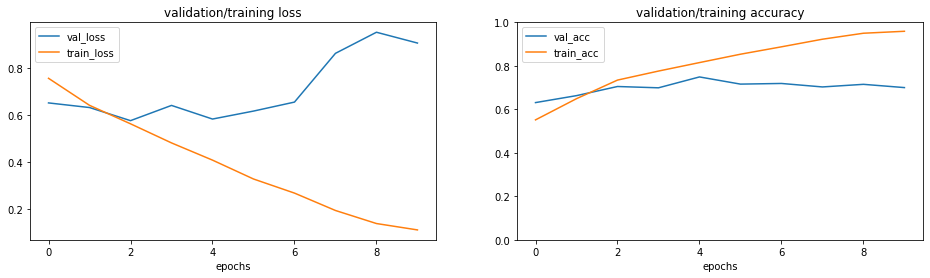

In [0]:
plot_training(history_A)

## Feature Extraction from PreTrained Model

In [0]:
# getting the pretrained model and freezing all layers

base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3)))
base_model.trainable = False

58892288/58889256 [==============================] - 6s 0us/step


In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
# adding the base_model to a block of fully connected layers
model_B = Sequential()
model_B.add(base_model)
model_B.add(Flatten())
model_B.add(Dense(256, activation='relu'))
model_B.add(Dense(1, activation='sigmoid'))

In [0]:
# Freezing the Conv layers from VGG16
for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [0]:
model_B.compile(optimizer=RMSprop(lr=0.0001), 
               loss='binary_crossentropy',
               metrics=['acc'])

In [0]:
history_B = model_B.fit_generator(train_gen, 
                     steps_per_epoch=(total_train // BATCH_SIZE),
                     validation_data=val_gen,
                     validation_steps=(total_val // BATCH_SIZE),
                     epochs = 10)

Epoch 1/10
100/100 [==============================] - 19s 195ms/step - loss: 0.3998 - acc: 0.8210 - val_loss: 0.3275 - val_acc: 0.8550
Epoch 2/10
100/100 [==============================] - 18s 184ms/step - loss: 0.2443 - acc: 0.9005 - val_loss: 0.3596 - val_acc: 0.8370
Epoch 3/10
100/100 [==============================] - 18s 185ms/step - loss: 0.1916 - acc: 0.9255 - val_loss: 0.3130 - val_acc: 0.8580
Epoch 4/10
100/100 [==============================] - 18s 184ms/step - loss: 0.1521 - acc: 0.9445 - val_loss: 0.2818 - val_acc: 0.8710
Epoch 5/10
100/100 [==============================] - 18s 183ms/step - loss: 0.1215 - acc: 0.9545 - val_loss: 0.3150 - val_acc: 0.8670
Epoch 6/10
100/100 [==============================] - 18s 185ms/step - loss: 0.0988 - acc: 0.9665 - val_loss: 0.3149 - val_acc: 0.8690
Epoch 7/10
100/100 [==============================] - 18s 184ms/step - loss: 0.0786 - acc: 0.9745 - val_loss: 0.2812 - val_acc: 0.8790
Epoch 8/10
100/100 [==============================] - 1

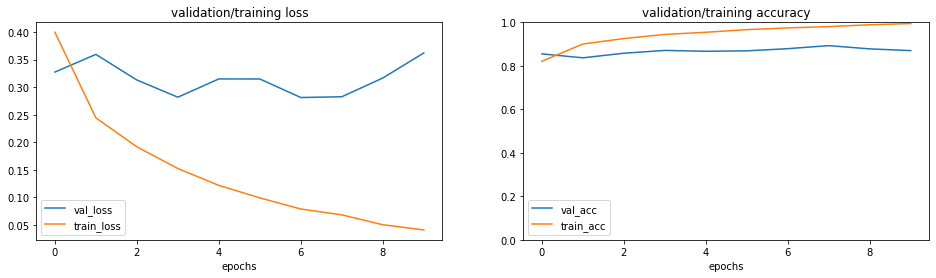

In [0]:
plot_training(history_B)

## Fine-Tuning Specific Layers of PreTrained Model

In [0]:
# adding the base_model to a block of fully connected layers
model_C = Sequential()
model_C.add(base_model)
model_C.add(Flatten())
model_C.add(Dense(256, activation='relu'))
model_C.add(Dense(1, activation='sigmoid'))

In [0]:
# Unfreezing the last conv_block
for layer in base_model.layers[15:]:
    layer.trainable = True

# Just ensuring the correct layers are frozen
for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [0]:
model_C.compile(optimizer=RMSprop(lr=0.0001), 
               loss='binary_crossentropy',
               metrics=['acc'])

In [0]:
history_C = model_C.fit_generator(train_gen, 
                     steps_per_epoch=(total_train // BATCH_SIZE),
                     validation_data=val_gen,
                     validation_steps=(total_val // BATCH_SIZE),
                     epochs = 10)

Epoch 1/10
100/100 [==============================] - 19s 186ms/step - loss: 0.3993 - acc: 0.8075 - val_loss: 0.3040 - val_acc: 0.8580
Epoch 2/10
100/100 [==============================] - 18s 183ms/step - loss: 0.2389 - acc: 0.9060 - val_loss: 0.2695 - val_acc: 0.8830
Epoch 3/10
100/100 [==============================] - 18s 184ms/step - loss: 0.1942 - acc: 0.9205 - val_loss: 0.2588 - val_acc: 0.8790
Epoch 4/10
100/100 [==============================] - 18s 185ms/step - loss: 0.1556 - acc: 0.9405 - val_loss: 0.2708 - val_acc: 0.8790
Epoch 5/10
100/100 [==============================] - 18s 184ms/step - loss: 0.1215 - acc: 0.9535 - val_loss: 0.2659 - val_acc: 0.8870
Epoch 6/10
100/100 [==============================] - 18s 184ms/step - loss: 0.1021 - acc: 0.9615 - val_loss: 0.2703 - val_acc: 0.8920
Epoch 7/10
100/100 [==============================] - 18s 184ms/step - loss: 0.0779 - acc: 0.9795 - val_loss: 0.2779 - val_acc: 0.8810
Epoch 8/10
100/100 [==============================] - 1

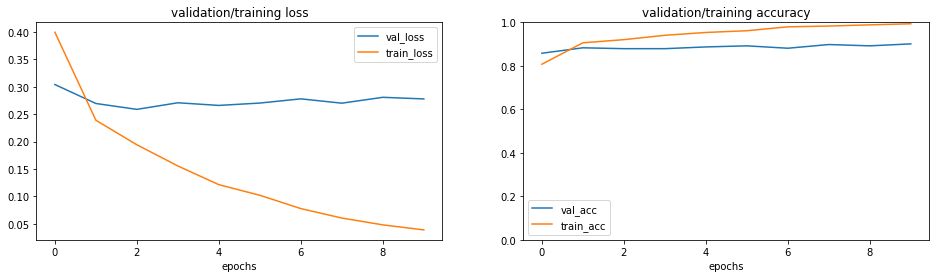

In [0]:
plot_training(history_C)